## Question 1

In [4]:
# Libraries

import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
import time
import json
import matplotlib.pyplot as plt

In [5]:
# Set work path
path = '/Users/fulin/Downloads'
os.chdir(path)

In [6]:
# load data with dask

start = time.time()
df = dd.read_csv(
    "COVID19_twitter_full_dataset.csv",
    dtype={
        'tweet_id': 'str',
        'user_id': 'str',
        'keyword': 'str',
        'country/region': 'str',
        'valence_intensity': 'float64',
        'fear_intensity': 'float64',
        'anger_intensity': 'float64',
        'happiness_intensity': 'float64',
        'sadness_intensity': 'float64',
        'sentiment': 'str',
        'emotion': 'str'
    }
)

# drop useless columns
df = df.drop('tweet_id', axis=1, errors='ignore')

# replace "NaN", "-", "null" to np.nan in the country/region columns
df['country/region'] = df['country/region'].replace(["NaN", "-", "null"], np.nan)

# convert tweet_timestamp into datetime，deal with errors
df['tweet_timestamp'] = dd.to_datetime(df['tweet_timestamp'], format='%Y-%m-%d %H-%M-%S', errors='coerce')

# Filter invalid datetime values
df = df.dropna(subset=['tweet_timestamp'])

# Add year/month/day column
df['year'] = df['tweet_timestamp'].dt.year
df['month'] = df['tweet_timestamp'].dt.month
df['day'] = df['tweet_timestamp'].dt.day

# Read the continent mapping file and convert the country/region column to the continent column
with open('country_continent_mapping.json') as f:
    country_continent_mapping = json.load(f)
df['continent'] = df['country/region'].map(country_continent_mapping)

# Delete rows with empty country/region column
df = df.dropna(subset=['country/region'])

# Calculate the total number of rows in a dataset
total_rows = df.shape[0].compute()

# --------------------------------------------------------------------------------------------------------------------------------
# !!!!! Here I just take a sub-dataset composed by 100000 observations according to long execution time and weak hardware capacity
# --------------------------------------------------------------------------------------------------------------------------------

frac = 100000 / total_rows
sampled_df = df.sample(frac=frac).compute()

# save in a csv file to save time for execution
sampled_df.to_csv('sampled_COVID19_twitter_dataset.csv', index=False)

end = time.time()
print("Time to read and process data:", end - start)
print(f'Sample data shape: {sampled_df.shape}')

Time to read and process data: 567.4293599128723
Sample data shape: (99997, 15)


In [7]:
# read the file
sampled_df = pd.read_csv('sampled_COVID19_twitter_dataset.csv')

# assume tweet_timestamp is datetime type
sampled_df['tweet_timestamp'] = pd.to_datetime(sampled_df['tweet_timestamp'], errors='coerce')

# check the data type converted
print(sampled_df['tweet_timestamp'].head())

# filter out invalid datetime values
sampled_df = sampled_df.dropna(subset=['tweet_timestamp'])

print(f'Sample data shape after filtering invalid dates: {sampled_df.shape}')

0   2020-01-31 13:27:35
1   2020-01-31 05:22:33
2   2020-01-31 21:40:06
3   2020-02-04 16:00:33
4   2020-02-03 07:01:39
Name: tweet_timestamp, dtype: datetime64[ns]
Sample data shape after filtering invalid dates: (99997, 15)


In [8]:
# take a look on the dataset
sampled_df.head()

,user_id,tweet_timestamp,keyword,country/region,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,year,month,day,continent
0,1159824326436229121,2020-01-31 13:27:35,wuhan,United States,0.423,0.537,0.421,0.206,0.483,negative,fear,2020,1,31,North America
1,3925359732,2020-01-31 05:22:33,corona,India,0.373,0.471,0.447,0.208,0.415,negative,fear,2020,1,31,Asia+Oceania
2,1161885853636890624,2020-01-31 21:40:06,wuhan,India,0.423,0.647,0.437,0.269,0.453,negative,fear,2020,1,31,Asia+Oceania
3,41085467,2020-02-04 16:00:33,wuhan,Singapore,0.544,0.488,0.398,0.341,0.357,positive,happiness,2020,2,4,Asia+Oceania
4,57233,2020-02-03 07:01:39,corona,United Kingdom,0.333,0.542,0.606,0.178,0.448,negative,anger,2020,2,3,Europe


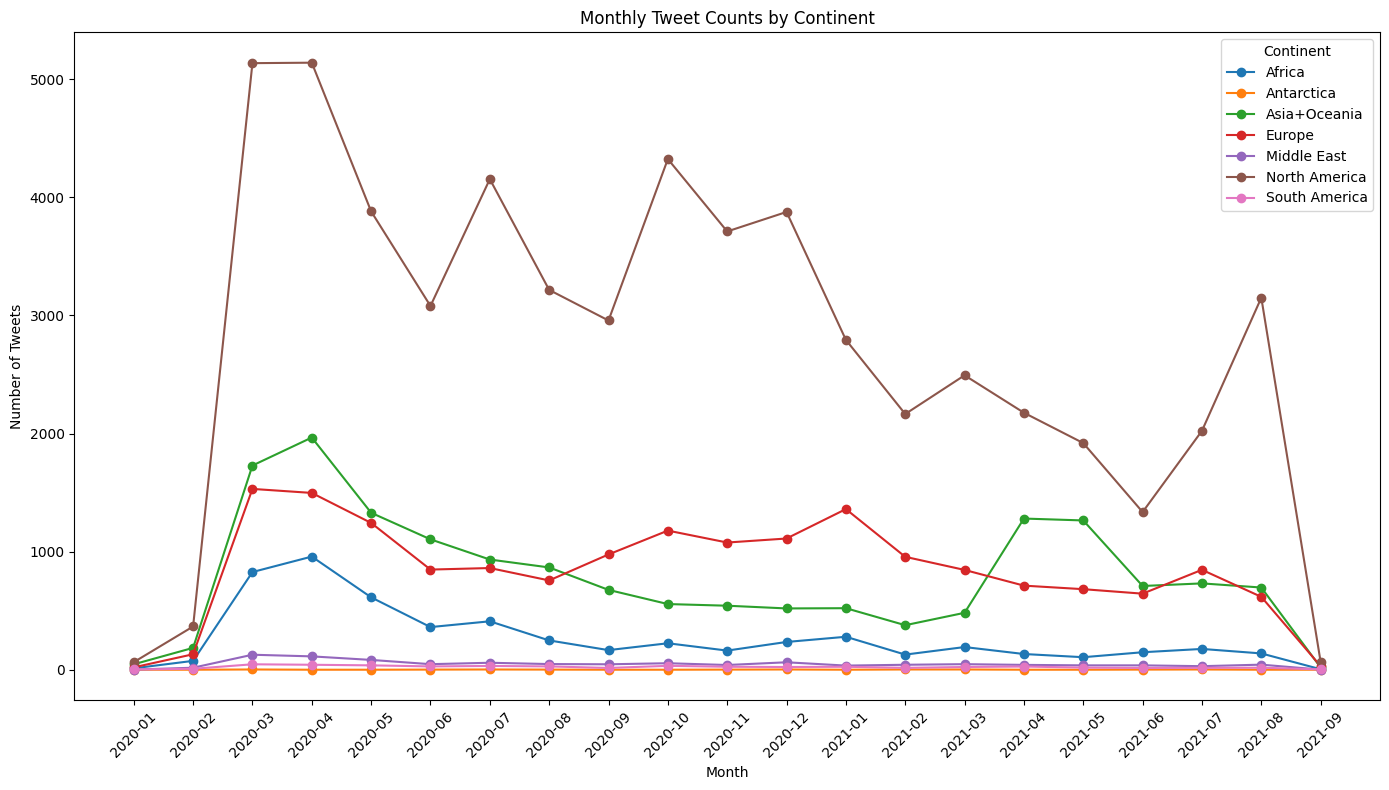

In [9]:
# extract the year / month
sampled_df['year_month'] = sampled_df['tweet_timestamp'].dt.to_period('M')

# compute the number of tweets by month and continent
monthly_tweet_counts = sampled_df.groupby(['year_month', 'continent']).size().unstack().fillna(0)

# plot
plt.figure(figsize=(14, 8))
for continent in monthly_tweet_counts.columns:
    plt.plot(monthly_tweet_counts.index.astype(str), monthly_tweet_counts[continent], marker='o', label=continent)
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.title('Monthly Tweet Counts by Continent')
plt.legend(title='Continent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Question 2

In [10]:
# Randomly sample 20% of the data
sample_df = sampled_df.sample(frac=0.2, random_state=42)
print(f'Sample data shape: {sample_df.shape}')

Sample data shape: (19999, 16)


In [11]:
from sklearn.cluster import KMeans

# features' selection
features = ['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']
X = sample_df[features].dropna()

print(f'X shape: {X.shape}')

# K-means
kmeans_2 = KMeans(n_clusters=2, random_state=42).fit(X)
kmeans_3 = KMeans(n_clusters=3, random_state=42).fit(X)

X shape: (19999, 5)


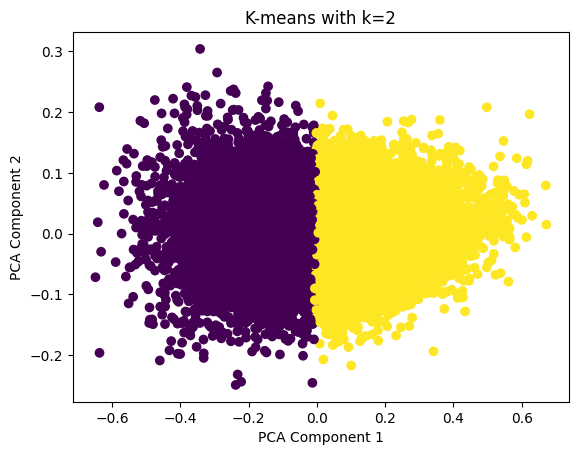

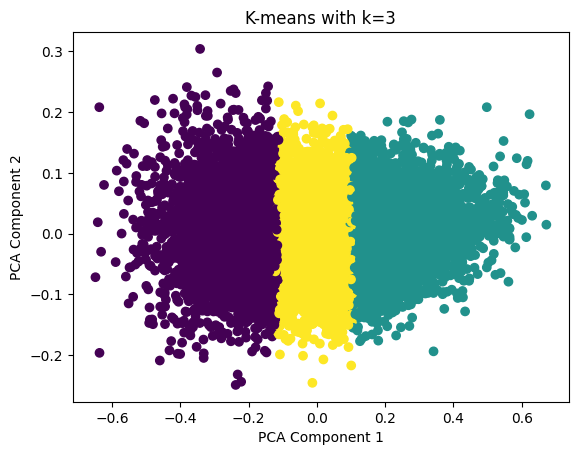

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# dim reduction by pca
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# viz
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

plot_clusters(X_pca, kmeans_2.labels_, 'K-means with k=2')
plot_clusters(X_pca, kmeans_3.labels_, 'K-means with k=3')

In [13]:
from sklearn.metrics import silhouette_score

# compute the Silhouette score
silhouette_score_2 = silhouette_score(X, kmeans_2.labels_)
silhouette_score_3 = silhouette_score(X, kmeans_3.labels_)

print(f'Silhouette Score for k=2: {silhouette_score_2}')
print(f'Silhouette Score for k=3: {silhouette_score_3}')

Silhouette Score for k=2: 0.41739173531089546
Silhouette Score for k=3: 0.3240152541349422


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# get sample_df's indexes
sample_indices = sample_df.index

# rest of 80% dataset
remaining_df = sampled_df.loc[~sampled_df.index.isin(sample_indices)]
print(f'Remaining data shape before dropna: {remaining_df.shape}')

# make sure the lengths of remaining_df and remaining_X match
remaining_X = remaining_df[features].dropna()
remaining_df = remaining_df.loc[remaining_X.index]

print(f'Remaining data shape after dropna: {remaining_df.shape}')
print(f'Remaining_X shape: {remaining_X.shape}')

# calculate cosine similarity and assign to clusters
cosine_sim_2 = cosine_similarity(remaining_X, kmeans_2.cluster_centers_)
cosine_sim_3 = cosine_similarity(remaining_X, kmeans_3.cluster_centers_)

# make sure the lengths match when assigning labels
remaining_labels_2 = np.argmax(cosine_sim_2, axis=1)
remaining_labels_3 = np.argmax(cosine_sim_3, axis=1)

print(f'Remaining labels 2 length: {len(remaining_labels_2)}')
print(f'Remaining labels 3 length: {len(remaining_labels_3)}')

remaining_df['cluster_2'] = remaining_labels_2
remaining_df['cluster_3'] = remaining_labels_3

Remaining data shape before dropna: (79998, 16)
Remaining data shape after dropna: (79998, 16)
Remaining_X shape: (79998, 5)
Remaining labels 2 length: 79998
Remaining labels 3 length: 79998


In [15]:
from sklearn.metrics import homogeneity_score

# calculate homogeneity score
homogeneity_20_3 = homogeneity_score(sample_df['sentiment'], kmeans_3.labels_)
print(f'Homogeneity Score for 20% data with k=3: {homogeneity_20_3}')

homogeneity_80_3 = homogeneity_score(remaining_df['sentiment'], remaining_df['cluster_3'])
print(f'Homogeneity Score for 80% data with k=3: {homogeneity_80_3}')

Homogeneity Score for 20% data with k=3: 0.4208224836348746
Homogeneity Score for 80% data with k=3: 0.42377200812340265


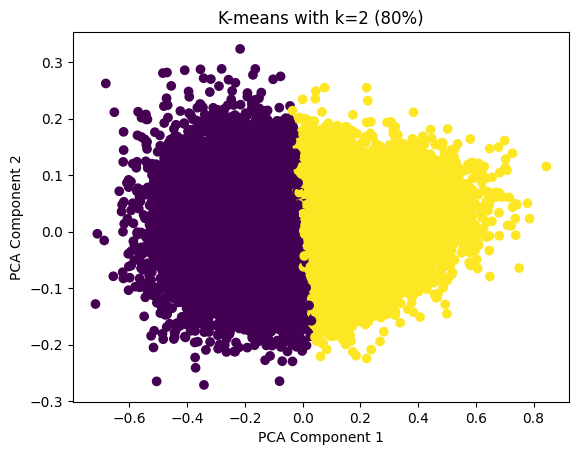

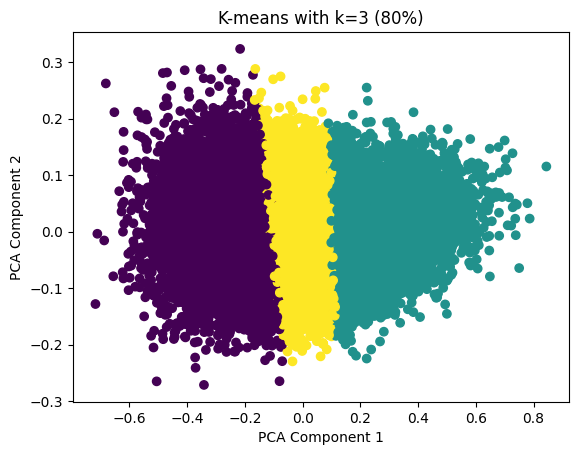

In [16]:
# PCA dimensionality reduction
remaining_X_pca = pca.transform(remaining_X)

# Visualize the clustering results of 80% of the data
plot_clusters(remaining_X_pca, remaining_labels_2, 'K-means with k=2 (80%)')
plot_clusters(remaining_X_pca, remaining_labels_3, 'K-means with k=3 (80%)')

## Question 3

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# stratified
stratified_sample_df, _ = train_test_split(sampled_df, test_size=0.8, stratify=sampled_df['sentiment'], random_state=42)

print(f'Stratified sample data shape: {stratified_sample_df.shape}')

Stratified sample data shape: (19999, 16)


In [19]:
from sklearn.cluster import KMeans

# features' selection
features = ['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']
X_stratified = stratified_sample_df[features].dropna()

print(f'X_stratified shape: {X_stratified.shape}')

# K-means clustering
kmeans_2_stratified = KMeans(n_clusters=2, random_state=42).fit(X_stratified)
kmeans_3_stratified = KMeans(n_clusters=3, random_state=42).fit(X_stratified)

X_stratified shape: (19999, 5)


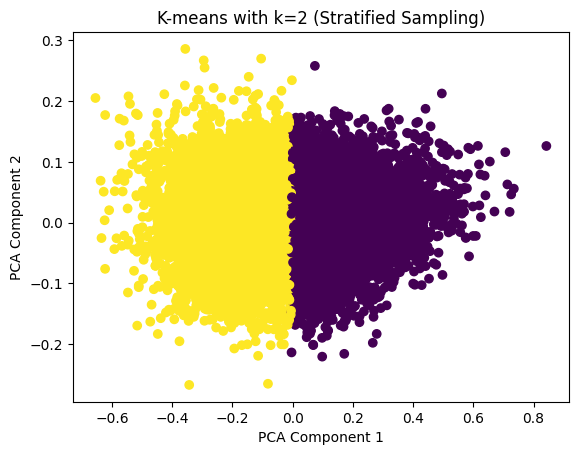

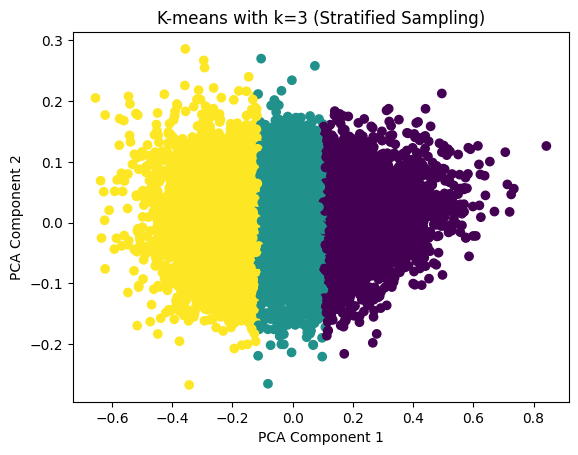

In [20]:
from sklearn.decomposition import PCA

# PCA dim reducttion
pca = PCA(n_components=2)
X_stratified_pca = pca.fit_transform(X_stratified)

# viz
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

plot_clusters(X_stratified_pca, kmeans_2_stratified.labels_, 'K-means with k=2 (Stratified Sampling)')
plot_clusters(X_stratified_pca, kmeans_3_stratified.labels_, 'K-means with k=3 (Stratified Sampling)')

In [21]:
from sklearn.metrics import silhouette_score

# silhouette score
silhouette_score_2_stratified = silhouette_score(X_stratified, kmeans_2_stratified.labels_)
silhouette_score_3_stratified = silhouette_score(X_stratified, kmeans_3_stratified.labels_)

print(f'Silhouette Score for k=2 (Stratified Sampling): {silhouette_score_2_stratified}')
print(f'Silhouette Score for k=3 (Stratified Sampling): {silhouette_score_3_stratified}')

Silhouette Score for k=2 (Stratified Sampling): 0.41738168428576405
Silhouette Score for k=3 (Stratified Sampling): 0.32332622920185083


In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# get stratified_sample_df index
stratified_sample_indices = stratified_sample_df.index

# 80% rest of data
remaining_df_stratified = sampled_df.loc[~sampled_df.index.isin(stratified_sample_indices)]
print(f'Remaining stratified data shape before dropna: {remaining_df_stratified.shape}')

# assume remaining_df_stratified and remaining_X_stratified have same lenth
remaining_X_stratified = remaining_df_stratified[features].dropna()
remaining_df_stratified = remaining_df_stratified.loc[remaining_X_stratified.index]

print(f'Remaining stratified data shape after dropna: {remaining_df_stratified.shape}')
print(f'Remaining_X_stratified shape: {remaining_X_stratified.shape}')

# calculate cosin simularity
cosine_sim_2_stratified = cosine_similarity(remaining_X_stratified, kmeans_2_stratified.cluster_centers_)
cosine_sim_3_stratified = cosine_similarity(remaining_X_stratified, kmeans_3_stratified.cluster_centers_)

# assume lenth matched
remaining_labels_2_stratified = np.argmax(cosine_sim_2_stratified, axis=1)
remaining_labels_3_stratified = np.argmax(cosine_sim_3_stratified, axis=1)

print(f'Remaining labels 2 stratified length: {len(remaining_labels_2_stratified)}')
print(f'Remaining labels 3 stratified length: {len(remaining_labels_3_stratified)}')

remaining_df_stratified['cluster_2'] = remaining_labels_2_stratified
remaining_df_stratified['cluster_3'] = remaining_labels_3_stratified

Remaining stratified data shape before dropna: (79998, 16)
Remaining stratified data shape after dropna: (79998, 16)
Remaining_X_stratified shape: (79998, 5)
Remaining labels 2 stratified length: 79998
Remaining labels 3 stratified length: 79998


In [23]:
from sklearn.metrics import homogeneity_score

# homogeneity
homogeneity_20_3_stratified = homogeneity_score(stratified_sample_df['sentiment'], kmeans_3_stratified.labels_)
print(f'Homogeneity Score for 20% stratified data with k=3: {homogeneity_20_3_stratified}')

homogeneity_80_3_stratified = homogeneity_score(remaining_df_stratified['sentiment'], remaining_df_stratified['cluster_3'])
print(f'Homogeneity Score for 80% stratified data with k=3: {homogeneity_80_3_stratified}')

Homogeneity Score for 20% stratified data with k=3: 0.4122551099768931
Homogeneity Score for 80% stratified data with k=3: 0.42546364069783355
